# CAPSTONE Project

## Study on Madrid tapas restaurants

<b>-----------------------------------------------------------------------------------------------------------------------------<b>

### Introduction

Madrid is the capital and most populous city of Spain. The city has almost 3.3 million inhabitants and a metropolitan area population of approximately 6.5 million. It is the second-largest city in the European Union (EU), surpassed only by Berlin, and its monocentric metropolitan area is the second-largest in the EU, smaller only than Paris. It is also very famous for its gastronomy and "tapas" culture. A tapa is an appetizer or snack in Spanish cuisine and translates to a small portion of any kind of Spanish food. Tapas may be cold (such as mixed olives and cheese) or hot (such as chopitos, which are battered, fried baby squid). In some bars and restaurants in Spain and across the globe tapas have evolved into a more sophisticated cuisine and can be combined to make even a full meal. The importance of this tradition is even more striking when we are are looking at the growing international tourism visiting the Community of Madrid from 2001 to 2018:

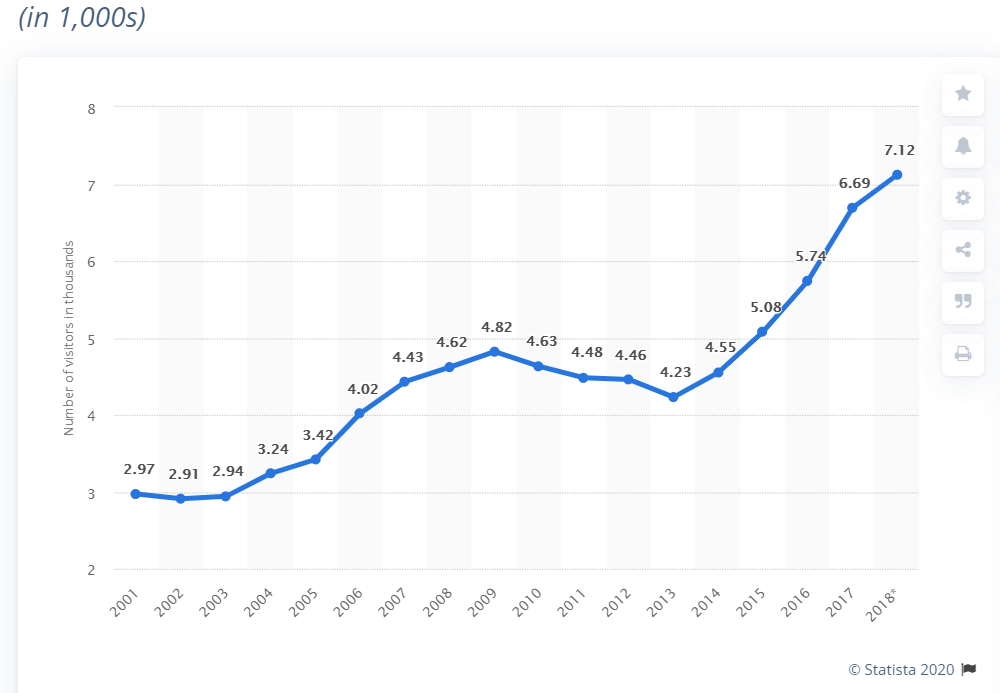




This project intends to help either those tourists who want to try the best tapas bars in the Spanish capital or the tour guides that are keen to amuse their group with the Spanish gastronomy. Moreover knowing the weak spots in the center areas can also be a good opportunity to open a new bar and fill the market niche.

## Data

In order to carry out a thorough analysis we need data on neighborhoods with latitude, longitude information and all the restaurants nearby with the corresponding ratings and tips.

The neighborhoods, latitudes and longitudes data of Madrid will be obtained from the following json data source: https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/madrid.geojson


Regarding locations, client ratings, tips of the tapas restaurants we will utilize the FourSquare API via the Request library in Python.

## Methodology

• Data collected from https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/madrid.geojson will be processed into a dataframe.

• FourSquare will be used to locate all venues. Data then gets filtered by tapas restaurants only. Ratings, tips and likes by users will be counted and added to the dataframe. Also exploratory statistics will be done to get better feel of the data.

• Data will be also sorted based on rankings to help the recommendation and get rid of the restaurants which dont have any ranking information.

• Finally the best rated neighbourhoods will be visualized to see the most attracting areas or potential market niches.

## Problem Statement/Questions to be asked


<li>What are the best neighborhoods in Madrid to eat tapas?</li>
<li>Which Neighborhoods have in general more tapas restaurants?</li>
<li>In which Neighborhood should I open a tapas restaurant to have better chance of success?</li>
 


In [11]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
#!conda install -c conda-forge folium=0.5.0 --yes
import folium 
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns
import wget
import json # library to handle JSON files

print('Done!')

Done!


In [12]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


In [13]:
CLIENT_ID = 'YBLV0QG20R03TB5FGAQSDJTMUY2I1QU1ZQ0RYHB5ZEL0WX4T' # your Foursquare ID
CLIENT_SECRET = '1OMSMMCZEUH5TKS3QWIGCQ0UF1BRW2TUK0TQAYKVX2K10RSG' # your Foursquare Secret
VERSION = '20190219' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YBLV0QG20R03TB5FGAQSDJTMUY2I1QU1ZQ0RYHB5ZEL0WX4T
CLIENT_SECRET:1OMSMMCZEUH5TKS3QWIGCQ0UF1BRW2TUK0TQAYKVX2K10RSG


In [16]:
def get_venues(lat,lng):
    #set variables
    radius=500
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_madrid_data():
    url='https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/madrid.geojson'
    wget.download(url, 'E:/Programs/Python/Madrid_data.json')
    with open('E:/Programs/Python/Madrid_data.json') as json_data:
        Madrid_data = json.load(json_data)
    # all data is present in features label
    features=Madrid_data['features']
    # define the dataframe columns
    column_names = ['Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    Madrid_df = pd.DataFrame(columns=column_names)
    for data in features:
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[0][0][0][1]
        neighborhood_lon = neighborhood_latlon[0][0][0][0]
        Madrid_df = Madrid_df.append({
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return Madrid_df

In [17]:
m_data = get_madrid_data()
m_data.head()

100% [............................................................................] 385601 / 385601

,Neighborhood,Latitude,Longitude
0,Palacio,40.421469,-3.704621
1,Embajadores,40.415489,-3.702619
2,Cortes,40.420457,-3.696740
3,Justicia,40.420149,-3.694245
4,Universidad,40.422511,-3.699856


In [51]:
# queens has most neighborhoods
# prepare neighborhood list that contains indian resturants
column_names=['Neighborhood', 'ID','Name']
tapas_madrid=pd.DataFrame(columns=column_names)
count=1
for row in m_data.values.tolist():
    Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    tapas_resturants=venues[venues['Category']=='Tapas Restaurant']   
    print('(',count,'/',len(m_data),')','Tapas restaurant in '+Neighborhood+':'+str(len(tapas_resturants)))
    print(row)
    for resturant_detail in tapas_resturants.values.tolist():
        id, name , category=resturant_detail
        tapas_madrid = tapas_madrid.append({
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 128 ) Tapas restaurant in Palacio:2
['Palacio', 40.421469, -3.704621]
( 2 / 128 ) Tapas restaurant in Embajadores:9
['Embajadores', 40.415489, -3.702619]
( 3 / 128 ) Tapas restaurant in Cortes:4
['Cortes', 40.420457, -3.69674]
( 4 / 128 ) Tapas restaurant in Justicia:2
['Justicia', 40.420149, -3.694245]
( 5 / 128 ) Tapas restaurant in Universidad:6
['Universidad', 40.422511, -3.699856]
( 6 / 128 ) Tapas restaurant in Sol:4
['Sol', 40.421442, -3.703529]
( 7 / 128 ) Tapas restaurant in Imperial:4
['Imperial', 40.402074, -3.713056]
( 8 / 128 ) Tapas restaurant in Acacias:3
['Acacias', 40.406379, -3.702577]
( 9 / 128 ) Tapas restaurant in Chopera:3
['Chopera', 40.392328, -3.693802]
( 10 / 128 ) Tapas restaurant in Legazpi:0
['Legazpi', 40.396262, -3.67853]
( 11 / 128 ) Tapas restaurant in Delicias:4
['Delicias', 40.402106, -3.694858]
( 12 / 128 ) Tapas restaurant in Palos de Moguer:3
['Palos de Moguer', 40.408379, -3.691649]
( 13 / 128 ) Tapas restaurant in Atocha:1
['Atocha', 40.404

( 101 / 128 ) Tapas restaurant in Palomas:1
['Palomas', 40.454157, -3.604401]
( 102 / 128 ) Tapas restaurant in Piovera:0
['Piovera', 40.463866, -3.635961]
( 103 / 128 ) Tapas restaurant in Canillas:0
['Canillas', 40.470054, -3.635622]
( 104 / 128 ) Tapas restaurant in Pinar del Rey:0
['Pinar del Rey', 40.475203, -3.632708]
( 105 / 128 ) Tapas restaurant in Apostol Santiago:0
['Apostol Santiago', 40.473961, -3.655266]
( 106 / 128 ) Tapas restaurant in Valdefuentes:0
['Valdefuentes', 40.5123, -3.651139]
( 107 / 128 ) Tapas restaurant in San AndrÃ©s:0
['San AndrÃ©s', 40.346841, -3.693191]
( 108 / 128 ) Tapas restaurant in San Cristobal:0
['San Cristobal', 40.33385, -3.690468]
( 109 / 128 ) Tapas restaurant in Butarque:0
['Butarque', 40.330468, -3.656212]
( 110 / 128 ) Tapas restaurant in Los Rosales:0
['Los Rosales', 40.347104, -3.691157]
( 111 / 128 ) Tapas restaurant in Los Angeles:1
['Los Angeles', 40.365712, -3.692696]
( 112 / 128 ) Tapas restaurant in Casco HistÃ³rico de Vallecas:0


In [20]:
tapas_madrid.to_csv('tapas_madrid_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [25]:
tapas_madrid = pd.read_csv('tapas_madrid_tocsv1.csv')
tapas_madrid = tapas_madrid[['Neighborhood','ID','Name']]

In [26]:
tapas_madrid.tail()

,Neighborhood,ID,Name
118,San Pascual,4b867556f964a520f18a31e3,La Abadia
119,San Pascual,4bdb3ffb3904a593d277499e,Bar Rodamari
120,Palomas,4c14bfd77f7f2d7f5d54e168,El Chiringo
121,Los Angeles,4e04fa4045dd8307ab68daa2,Bar Maty
122,Amposta,4f5225eae4b0bf6b5cc57cac,Sidrería Del Norte II


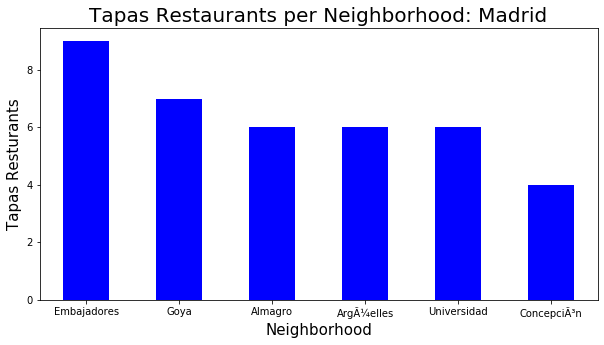

In [27]:
NOofNeigh = 6 # top number for graphing all the same past 6
tapas_madrid.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color='blue')
plt.title('Tapas Restaurants per Neighborhood: Madrid', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Tapas Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [28]:
column_names=['Neighborhood', 'ID','Name','Likes','Rating','Tips']
tapas_restaurants_stats_mad=pd.DataFrame(columns=column_names)
count=1
for row in tapas_madrid.values.tolist():
    Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(tapas_madrid),')','processed')
    tapas_restaurants_stats_mad = tapas_restaurants_stats_mad.append({
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
tapas_restaurants_stats_mad.tail()

{'meta': {'code': 200, 'requestId': '5e50efa7963d29001b0d9a83'}, 'response': {'venue': {'id': '4b6c96b0f964a520f9442ce3', 'name': 'Pontepez', 'contact': {'phone': '+34915232933', 'formattedPhone': '+34 915 23 29 33', 'twitter': 'pontepez', 'facebook': '283892695000946', 'facebookUsername': 'Pontepez', 'facebookName': 'Pontepez'}, 'location': {'address': 'Pez, 18', 'crossStreet': 'Calle Pizarro', 'lat': 40.42377716955972, 'lng': -3.7054651587022125, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42377716955972, 'lng': -3.7054651587022125}], 'postalCode': '28004', 'cc': 'ES', 'neighborhood': 'Malasaña', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Pez, 18 (Calle Pizarro)', '28004 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/pontepez/4b6c96b0f964a520f9442ce3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4s

{'meta': {'code': 200, 'requestId': '5e50efd4211536001b0d67e7'}, 'response': {'venue': {'id': '552cc0cd498e4bba96669cb2', 'name': 'Pez Tortilla', 'contact': {'phone': '+34653919984', 'formattedPhone': '+34 653 91 99 84', 'twitter': 'peztortilla', 'facebook': '1578334149105150', 'facebookUsername': 'peztortilla', 'facebookName': 'Pez Tortilla'}, 'location': {'address': 'C. Pez, 36', 'lat': 40.4242382067626, 'lng': -3.706568309829162, 'labeledLatLngs': [{'label': 'display', 'lat': 40.4242382067626, 'lng': -3.706568309829162}], 'postalCode': '28004', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Pez, 36', '28004 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/pez-tortilla/552cc0cd498e4bba96669cb2', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'

{'meta': {'code': 200, 'requestId': '5e50f05814a126001bc86ca7'}, 'response': {'venue': {'id': '57442b9e498eb4d238e3bece', 'name': 'InClan Brutal Bar', 'contact': {'phone': '+34910238038', 'formattedPhone': '+34 910 23 80 38', 'instagram': 'inclanbrutalbar', 'facebook': '1734777306768910', 'facebookUsername': 'inclanbrutalbar', 'facebookName': 'InClan Brutal Bar'}, 'location': {'address': 'Calle de Álvarez Gato, 4', 'lat': 40.41502338061646, 'lng': -3.7018643661445174, 'labeledLatLngs': [{'label': 'display', 'lat': 40.41502338061646, 'lng': -3.7018643661445174}], 'postalCode': '28012', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Calle de Álvarez Gato, 4', '28012 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/inclan-brutal-bar/57442b9e498eb4d238e3bece', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.

{'meta': {'code': 200, 'requestId': '5e50f094618f43001b1560db'}, 'response': {'venue': {'id': '5478dde0498eab68d4d6423f', 'name': 'Rosi La Loca', 'contact': {'phone': '+34915326681', 'formattedPhone': '+34 915 32 66 81', 'twitter': 'rosi_la_loca', 'instagram': 'rosilalocataberna', 'facebook': '750769271662878', 'facebookUsername': 'RosiLaLocaBar', 'facebookName': 'Rosi La Loca Taberna'}, 'location': {'address': 'Calle Cadiz 4', 'lat': 40.415821011717526, 'lng': -3.7029546044326276, 'labeledLatLngs': [{'label': 'display', 'lat': 40.415821011717526, 'lng': -3.7029546044326276}], 'postalCode': '28012', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Calle Cadiz 4', '28012 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/rosi-la-loca/5478dde0498eab68d4d6423f', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4

{'meta': {'code': 200, 'requestId': '5e50efeab4b684001bd88a29'}, 'response': {'venue': {'id': '4bd82971dc4b952103737888', 'name': 'Taberna Malaspina', 'contact': {'phone': '+34915234024', 'formattedPhone': '+34 915 23 40 24', 'facebook': '338704939500038', 'facebookName': 'Taberna Malaspina Madrid'}, 'location': {'address': 'C. Cádiz, 9', 'crossStreet': 'C. Barcelona', 'lat': 40.415766581101096, 'lng': -3.702643769694344, 'labeledLatLngs': [{'label': 'display', 'lat': 40.415766581101096, 'lng': -3.702643769694344}], 'postalCode': '28012', 'cc': 'ES', 'neighborhood': 'Sol', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Cádiz, 9 (C. Barcelona)', '28012 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/taberna-malaspina/4bd82971dc4b952103737888', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categorie

{'meta': {'code': 200, 'requestId': '5e50f0273907e70024d866aa'}, 'response': {'venue': {'id': '4b5f3d9cf964a52076af29e3', 'name': 'Museo del Jamón', 'contact': {'phone': '+34915210346', 'formattedPhone': '+34 915 21 03 46'}, 'location': {'address': 'Carrera de San Jerónimo, 6', 'lat': 40.41665890338383, 'lng': -3.7015152430287395, 'labeledLatLngs': [{'label': 'display', 'lat': 40.41665890338383, 'lng': -3.7015152430287395}], 'postalCode': '28014', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Carrera de San Jerónimo, 6', '28014 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/museo-del-jam%C3%B3n/4b5f3d9cf964a52076af29e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d150941735', 'name': 'Spanish Resta

{'meta': {'code': 200, 'requestId': '5e50f02f9388d7001b65abf1'}, 'response': {'venue': {'id': '4adcda34f964a520f73a21e3', 'name': 'Casa Labra', 'contact': {'phone': '+34915310081', 'formattedPhone': '+34 915 31 00 81'}, 'location': {'address': 'C. Tetuán, 12', 'lat': 40.41715, 'lng': -3.7045143, 'labeledLatLngs': [{'label': 'display', 'lat': 40.41715, 'lng': -3.7045143}], 'postalCode': '28013', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Tetuán, 12', '28013 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/casa-labra/4adcda34f964a520f73a21e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1c7941735', 'name': 'Snack Place', 'pluralName': 'Snack Places', 'shortName': 'Snacks', 'icon': {'prefix': 'htt

{'meta': {'code': 200, 'requestId': '5e50ef9740a7ea001bed1375'}, 'response': {'venue': {'id': '4be5ada39026ef3b9ac30a38', 'name': 'La Casa del Abuelo', 'contact': {'phone': '+34910000133', 'formattedPhone': '+34 910 00 01 33'}, 'location': {'address': 'C. Victoria, 12', 'lat': 40.4158078467863, 'lng': -3.701593251107847, 'labeledLatLngs': [{'label': 'display', 'lat': 40.4158078467863, 'lng': -3.701593251107847}], 'postalCode': '28012', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Victoria, 12', '28012 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/la-casa-del-abuelo/4be5ada39026ef3b9ac30a38', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d150941735', 'name': 'Spanish Restaurant', 'pluralName': 'Sp

{'meta': {'code': 200, 'requestId': '5e50f00098205d001b8a63b2'}, 'response': {'venue': {'id': '4b8311b5f964a520b9f530e3', 'name': 'Matador', 'contact': {'phone': '+34915318981', 'formattedPhone': '+34 915 31 89 81'}, 'location': {'address': 'C/ de la Cruz 39', 'lat': 40.4146306440801, 'lng': -3.7029469756383695, 'labeledLatLngs': [{'label': 'display', 'lat': 40.4146306440801, 'lng': -3.7029469756383695}], 'postalCode': '28012', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C/ de la Cruz 39', '28012 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/matador/4b8311b5f964a520b9f530e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': 

{'meta': {'code': 200, 'requestId': '5e50f09c9fcb92001b1494e6'}, 'response': {'venue': {'id': '4ba3e8e1f964a520c06c38e3', 'name': 'Lateral', 'contact': {'phone': '+34914201582', 'formattedPhone': '+34 914 20 15 82', 'twitter': 'rest_lateral', 'facebook': '437140316312519', 'facebookUsername': 'restauranteslateral', 'facebookName': 'Restaurantes Lateral'}, 'location': {'address': 'Pl. de Santa Ana, 12', 'lat': 40.41457050395633, 'lng': -3.701133477680609, 'labeledLatLngs': [{'label': 'display', 'lat': 40.41457050395633, 'lng': -3.701133477680609}], 'postalCode': '28012', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Pl. de Santa Ana, 12', '28012 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/lateral/4ba3e8e1f964a520c06c38e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/fo

{'meta': {'code': 200, 'requestId': '5e50f04b47e0d60026e8101f'}, 'response': {'venue': {'id': '4b3e424af964a520469a25e3', 'name': 'Taberna La Alhambra', 'contact': {'phone': '+34915210708', 'formattedPhone': '+34 915 21 07 08'}, 'location': {'address': 'C. Victoria, 9', 'lat': 40.41598856760646, 'lng': -3.701659335545549, 'labeledLatLngs': [{'label': 'display', 'lat': 40.41598856760646, 'lng': -3.701659335545549}], 'postalCode': '28012', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Victoria, 9', '28012 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/taberna-la-alhambra/4b3e424af964a520469a25e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d150941735', 'name': 'Spanish Restaurant', 'pluralName': '

{'meta': {'code': 200, 'requestId': '5e50f08abe61c9001b893653'}, 'response': {'venue': {'id': '5d4894d27928f300087e89b7', 'name': 'Vinitus', 'contact': {}, 'location': {'address': 'Gran Vía 4', 'lat': 40.419236, 'lng': -3.697726, 'labeledLatLngs': [{'label': 'display', 'lat': 40.419236, 'lng': -3.697726}], 'postalCode': '28013', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Gran Vía 4', '28013 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/vinitus/5d4894d27928f300087e89b7', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 5, 'groups': [{'type': 'others', 'count': 5, 'items': [{'id': '12089067', 'firs

{'meta': {'code': 200, 'requestId': '5e50f07d9da7ee001b49038d'}, 'response': {'venue': {'id': '4b2563d4f964a520197124e3', 'name': 'Mercado de la Reina', 'contact': {'phone': '+34915213198', 'formattedPhone': '+34 915 21 31 98', 'twitter': 'mercadodlareina', 'facebook': '172258932808264', 'facebookUsername': 'MercadodelaReina', 'facebookName': 'Restaurante Mercado de la Reina'}, 'location': {'address': 'C. Gran Vía, 12', 'lat': 40.419531818561246, 'lng': -3.6988707977016086, 'labeledLatLngs': [{'label': 'display', 'lat': 40.419531818561246, 'lng': -3.6988707977016086}], 'postalCode': '28013', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Gran Vía, 12', '28013 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/mercadodlareina', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food

{'meta': {'code': 200, 'requestId': '5e50f035b9a389001b241d91'}, 'response': {'venue': {'id': '5abe40873c858d57567ab8ed', 'name': 'La Buha', 'contact': {}, 'location': {'address': 'Calle Pelayo', 'lat': 40.423134, 'lng': -3.69815, 'labeledLatLngs': [{'label': 'display', 'lat': 40.423134, 'lng': -3.69815}], 'postalCode': '28004', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Calle Pelayo', '28004 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/la-buha/5abe40873c858d57567ab8ed', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 10, 'groups': [{'type': 'others', 'count': 10, 'items': []}], 'summary': '10 

{'meta': {'code': 200, 'requestId': '5e50efcc95feaf001bac2824'}, 'response': {'venue': {'id': '5d4894d27928f300087e89b7', 'name': 'Vinitus', 'contact': {}, 'location': {'address': 'Gran Vía 4', 'lat': 40.419236, 'lng': -3.697726, 'labeledLatLngs': [{'label': 'display', 'lat': 40.419236, 'lng': -3.697726}], 'postalCode': '28013', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Gran Vía 4', '28013 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/vinitus/5d4894d27928f300087e89b7', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 5, 'groups': [{'type': 'others', 'count': 5, 'items': [{'id': '12089067', 'firs

{'meta': {'code': 200, 'requestId': '5e50f04c69babe001bfa8d43'}, 'response': {'venue': {'id': '4b2563d4f964a520197124e3', 'name': 'Mercado de la Reina', 'contact': {'phone': '+34915213198', 'formattedPhone': '+34 915 21 31 98', 'twitter': 'mercadodlareina', 'facebook': '172258932808264', 'facebookUsername': 'MercadodelaReina', 'facebookName': 'Restaurante Mercado de la Reina'}, 'location': {'address': 'C. Gran Vía, 12', 'lat': 40.419531818561246, 'lng': -3.6988707977016086, 'labeledLatLngs': [{'label': 'display', 'lat': 40.419531818561246, 'lng': -3.6988707977016086}], 'postalCode': '28013', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Gran Vía, 12', '28013 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/mercadodlareina', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food

{'meta': {'code': 200, 'requestId': '5e50f078216785001c6aef22'}, 'response': {'venue': {'id': '535a5a5f498e9880fbf374c0', 'name': 'Mercado de San Ildefonso', 'contact': {'twitter': 'msanildefonso', 'facebook': '1922005497938455', 'facebookUsername': 'MercadoSanIldefonso', 'facebookName': 'Mercado de San Ildefonso'}, 'location': {'address': 'C. Fuencarral, 57', 'lat': 40.42423010607013, 'lng': -3.700819251110139, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42423010607013, 'lng': -3.700819251110139}], 'postalCode': '28004', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Fuencarral, 57', '28004 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/mercado-de-san-ildefonso/535a5a5f498e9880fbf374c0', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}

{'meta': {'code': 200, 'requestId': '5e50f08b6001fe001b5893e4'}, 'response': {'venue': {'id': '5abe40873c858d57567ab8ed', 'name': 'La Buha', 'contact': {}, 'location': {'address': 'Calle Pelayo', 'lat': 40.423134, 'lng': -3.69815, 'labeledLatLngs': [{'label': 'display', 'lat': 40.423134, 'lng': -3.69815}], 'postalCode': '28004', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Calle Pelayo', '28004 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/la-buha/5abe40873c858d57567ab8ed', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 10, 'groups': [{'type': 'others', 'count': 10, 'items': []}], 'summary': '10 

{'meta': {'code': 200, 'requestId': '5e50f06aedbcad001ba9df72'}, 'response': {'venue': {'id': '4d1ccdcac68aa1cdffd2a5e2', 'name': 'La Tita Rivera', 'contact': {'phone': '+34915221890', 'formattedPhone': '+34 915 22 18 90', 'twitter': 'latitarivera', 'facebook': '180160918666598', 'facebookUsername': 'LaTitaRivera', 'facebookName': 'La TiTA Rivera'}, 'location': {'address': 'C. Perez Galdós, 4', 'lat': 40.42236378502141, 'lng': -3.7003691876569693, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42236378502141, 'lng': -3.7003691876569693}], 'postalCode': '28004', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Perez Galdós, 4', '28004 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/latitarivera', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '5e50f05f83525f001ce9ee31'}, 'response': {'venue': {'id': '4adcda36f964a5209b3b21e3', 'name': 'Lateral', 'contact': {'phone': '+34915316877', 'formattedPhone': '+34 915 31 68 77', 'twitter': 'rest_lateral', 'facebook': '437140316312519', 'facebookUsername': 'restauranteslateral', 'facebookName': 'Restaurantes Lateral'}, 'location': {'address': 'C. Fuencarral, 43', 'lat': 40.42313488092766, 'lng': -3.700817360501268, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42313488092766, 'lng': -3.700817360501268}], 'postalCode': '28004', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Fuencarral, 43', '28004 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/lateral/4adcda36f964a5209b3b21e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tap

{'meta': {'code': 200, 'requestId': '5e50f0870be7b4001b700c5c'}, 'response': {'venue': {'id': '4b2563d4f964a520197124e3', 'name': 'Mercado de la Reina', 'contact': {'phone': '+34915213198', 'formattedPhone': '+34 915 21 31 98', 'twitter': 'mercadodlareina', 'facebook': '172258932808264', 'facebookUsername': 'MercadodelaReina', 'facebookName': 'Restaurante Mercado de la Reina'}, 'location': {'address': 'C. Gran Vía, 12', 'lat': 40.419531818561246, 'lng': -3.6988707977016086, 'labeledLatLngs': [{'label': 'display', 'lat': 40.419531818561246, 'lng': -3.6988707977016086}], 'postalCode': '28013', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Gran Vía, 12', '28013 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/mercadodlareina', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food

{'meta': {'code': 200, 'requestId': '5e50f0430cc1fd001bb1c8f6'}, 'response': {'venue': {'id': '4b6c96b0f964a520f9442ce3', 'name': 'Pontepez', 'contact': {'phone': '+34915232933', 'formattedPhone': '+34 915 23 29 33', 'twitter': 'pontepez', 'facebook': '283892695000946', 'facebookUsername': 'Pontepez', 'facebookName': 'Pontepez'}, 'location': {'address': 'Pez, 18', 'crossStreet': 'Calle Pizarro', 'lat': 40.42377716955972, 'lng': -3.7054651587022125, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42377716955972, 'lng': -3.7054651587022125}], 'postalCode': '28004', 'cc': 'ES', 'neighborhood': 'Malasaña', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Pez, 18 (Calle Pizarro)', '28004 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/pontepez/4b6c96b0f964a520f9442ce3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4s

{'meta': {'code': 200, 'requestId': '5e50f0050f5968001bc276ad'}, 'response': {'venue': {'id': '552cc0cd498e4bba96669cb2', 'name': 'Pez Tortilla', 'contact': {'phone': '+34653919984', 'formattedPhone': '+34 653 91 99 84', 'twitter': 'peztortilla', 'facebook': '1578334149105150', 'facebookUsername': 'peztortilla', 'facebookName': 'Pez Tortilla'}, 'location': {'address': 'C. Pez, 36', 'lat': 40.4242382067626, 'lng': -3.706568309829162, 'labeledLatLngs': [{'label': 'display', 'lat': 40.4242382067626, 'lng': -3.706568309829162}], 'postalCode': '28004', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Pez, 36', '28004 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/pez-tortilla/552cc0cd498e4bba96669cb2', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'

{'meta': {'code': 200, 'requestId': '5e50f05e7828ae001b80ae50'}, 'response': {'venue': {'id': '4d1ccdcac68aa1cdffd2a5e2', 'name': 'La Tita Rivera', 'contact': {'phone': '+34915221890', 'formattedPhone': '+34 915 22 18 90', 'twitter': 'latitarivera', 'facebook': '180160918666598', 'facebookUsername': 'LaTitaRivera', 'facebookName': 'La TiTA Rivera'}, 'location': {'address': 'C. Perez Galdós, 4', 'lat': 40.42236378502141, 'lng': -3.7003691876569693, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42236378502141, 'lng': -3.7003691876569693}], 'postalCode': '28004', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Perez Galdós, 4', '28004 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/latitarivera', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '5e50f07fc8cff2001cc443dd'}, 'response': {'venue': {'id': '535a5a5f498e9880fbf374c0', 'name': 'Mercado de San Ildefonso', 'contact': {'twitter': 'msanildefonso', 'facebook': '1922005497938455', 'facebookUsername': 'MercadoSanIldefonso', 'facebookName': 'Mercado de San Ildefonso'}, 'location': {'address': 'C. Fuencarral, 57', 'lat': 40.42423010607013, 'lng': -3.700819251110139, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42423010607013, 'lng': -3.700819251110139}], 'postalCode': '28004', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Fuencarral, 57', '28004 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/mercado-de-san-ildefonso/535a5a5f498e9880fbf374c0', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}

{'meta': {'code': 200, 'requestId': '5e50f0ad77af03001bbb57ed'}, 'response': {'venue': {'id': '579cf78d498ed2eebf959c80', 'name': 'Sidreria Asgaya', 'contact': {'phone': '+34915028605', 'formattedPhone': '+34 915 02 86 05'}, 'location': {'address': 'Calle Toledo, 170', 'lat': 40.402687, 'lng': -3.7138362, 'labeledLatLngs': [{'label': 'display', 'lat': 40.402687, 'lng': -3.7138362}], 'postalCode': '28005', 'cc': 'ES', 'neighborhood': 'Imperial', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Calle Toledo, 170', '28005 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/sidreria-asgaya/579cf78d498ed2eebf959c80', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 3, 'message': 'Expensi

{'meta': {'code': 200, 'requestId': '5e50f0ad77af03001bbb58ea'}, 'response': {'venue': {'id': '536a8706498e6426d5d6ba6b', 'name': 'El 7 de Zahonero', 'contact': {'phone': '+34915134896', 'formattedPhone': '+34 915 13 48 96'}, 'location': {'address': 'Paseo de las Yeserías 7', 'lat': 40.40033472928856, 'lng': -3.7122992730998177, 'labeledLatLngs': [{'label': 'display', 'lat': 40.40033472928856, 'lng': -3.7122992730998177}], 'postalCode': '28005', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Paseo de las Yeserías 7', '28005 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/el-7-de-zahonero/536a8706498e6426d5d6ba6b', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 6}, 'url': 'http://elsiet

{'meta': {'code': 200, 'requestId': '5e50f05c1e152c001b4e27db'}, 'response': {'venue': {'id': '4d692a050a25b60cc0222190', 'name': 'Cerveceria Ruyma', 'contact': {}, 'location': {'address': 'P. de los Pontones, 20', 'lat': 40.404255611015216, 'lng': -3.717923923929534, 'labeledLatLngs': [{'label': 'display', 'lat': 40.404255611015216, 'lng': -3.717923923929534}], 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['P. de los Pontones, 20', 'Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/cerveceria-ruyma/4d692a050a25b60cc0222190', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 5, 'groups': [{'type': 'others

{'meta': {'code': 200, 'requestId': '5e50efa4bae9a2001bc093ed'}, 'response': {'venue': {'id': '533c419a498e2d22ba0e0780', 'name': 'Juan Raro', 'contact': {'phone': '+34910858136', 'formattedPhone': '+34 910 85 81 36', 'instagram': 'juan_raro'}, 'location': {'address': 'C. Miguel Servet', 'lat': 40.407007881585116, 'lng': -3.7010805819249994, 'labeledLatLngs': [{'label': 'display', 'lat': 40.407007881585116, 'lng': -3.7010805819249994}], 'postalCode': '28012', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Miguel Servet', '28012 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/juan-raro/533c419a498e2d22ba0e0780', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 22}, 'url': 'http://www.

{'meta': {'code': 200, 'requestId': '5e50f0379388d7001b65c8d2'}, 'response': {'venue': {'id': '4b8a753bf964a5208b6d32e3', 'name': 'El Capricho Extremeño', 'contact': {'phone': '+34913655841', 'formattedPhone': '+34 913 65 58 41'}, 'location': {'address': 'C. Carlos Arniches, 30', 'lat': 40.407090407096, 'lng': -3.70826083435309, 'labeledLatLngs': [{'label': 'display', 'lat': 40.407090407096, 'lng': -3.70826083435309}], 'postalCode': '28005', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Carlos Arniches, 30', '28005 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/el-capricho-extreme%C3%B1o/4b8a753bf964a5208b6d32e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 54}, 'price': {'tie

{'meta': {'code': 200, 'requestId': '5e50f08a949393001b45ab66'}, 'response': {'venue': {'id': '4baf453af964a520b0f43be3', 'name': 'Taberna La Mina', 'contact': {'phone': '+34915390030', 'formattedPhone': '+34 915 39 00 30'}, 'location': {'address': 'C. Ave María, 28', 'lat': 40.41059917405741, 'lng': -3.7007834971182523, 'labeledLatLngs': [{'label': 'display', 'lat': 40.41059917405741, 'lng': -3.7007834971182523}], 'postalCode': '28012', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Ave María, 28', '28012 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/taberna-la-mina/4baf453af964a520b0f43be3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d150941735', 'name': 'Spanish Restaurant', 'pluralName': 'Sp

{'meta': {'code': 200, 'requestId': '5e50f07e542890001b0b22f5'}, 'response': {'venue': {'id': '4bc1c5aa920eb7135d1d1b2c', 'name': 'Taberna Restaurante Bacanal', 'contact': {'phone': '+34915063688', 'formattedPhone': '+34 915 06 36 88'}, 'location': {'address': 'C. Bolívar, 11', 'lat': 40.3924432838869, 'lng': -3.692116242852847, 'labeledLatLngs': [{'label': 'display', 'lat': 40.3924432838869, 'lng': -3.692116242852847}], 'postalCode': '28045', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Bolívar, 11', '28045 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/taberna-restaurante-bacanal/4bc1c5aa920eb7135d1d1b2c', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d150941735', 'name': 'Spanish Restaurant', '

{'meta': {'code': 200, 'requestId': '5e50f05e1e152c001b4e2ed0'}, 'response': {'venue': {'id': '5936ff9059fe5c731403614c', 'name': 'Bar Bonsai', 'contact': {}, 'location': {'address': 'Calle del Rodio 4', 'lat': 40.390495, 'lng': -3.6920712, 'labeledLatLngs': [{'label': 'display', 'lat': 40.390495, 'lng': -3.6920712}], 'postalCode': '28045', 'cc': 'ES', 'neighborhood': 'Legazpi', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Calle del Rodio 4', '28045 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/bar-bonsai/5936ff9059fe5c731403614c', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 3, 'groups': [{'type': 'others

{'meta': {'code': 200, 'requestId': '5e50ef45dd0f850029528657'}, 'response': {'venue': {'id': '4b83c5dff964a520e10f31e3', 'name': 'La Pequeña Graná', 'contact': {}, 'location': {'address': 'C. General Palanca, 16', 'lat': 40.39957392916725, 'lng': -3.6985499739321477, 'labeledLatLngs': [{'label': 'display', 'lat': 40.39957392916725, 'lng': -3.6985499739321477}], 'postalCode': '28045', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. General Palanca, 16', '28045 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/la-peque%C3%B1a-gran%C3%A1/4b83c5dff964a520e10f31e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 66}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '€'}, 'likes': {

{'meta': {'code': 200, 'requestId': '5e50efe1211536001b0d936b'}, 'response': {'venue': {'id': '4fe384a2e4b0c7d06f7ad2f1', 'name': 'El Rincón Asturiano', 'contact': {}, 'location': {'address': 'C. Ancora, 32', 'lat': 40.402836280139326, 'lng': -3.689974503075221, 'labeledLatLngs': [{'label': 'display', 'lat': 40.402836280139326, 'lng': -3.689974503075221}], 'postalCode': '28045', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Ancora, 32', '28045 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/el-rinc%C3%B3n-asturiano/4fe384a2e4b0c7d06f7ad2f1', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 17, 'gro

{'meta': {'code': 200, 'requestId': '5e50f07160ba08001bbee82b'}, 'response': {'venue': {'id': '4c542219a724e21e443ae0f5', 'name': 'Taberna Almeria II', 'contact': {}, 'location': {'address': 'Ferrocarril 33', 'lat': 40.40104077395461, 'lng': -3.697189131248308, 'labeledLatLngs': [{'label': 'display', 'lat': 40.40104077395461, 'lng': -3.697189131248308}], 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Ferrocarril 33', 'Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/taberna-almeria-ii/4c542219a724e21e443ae0f5', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 10, 'groups': [{'type': 'others', 'count': 1

{'meta': {'code': 200, 'requestId': '5e50efe61835dd001bb2c19a'}, 'response': {'venue': {'id': '4bbe38155ce0d13a3ecfdf57', 'name': 'Lacaña', 'contact': {'phone': '+34915272269', 'formattedPhone': '+34 915 27 22 69'}, 'location': {'address': 'C. Santa Isabel, 50', 'lat': 40.40904946660318, 'lng': -3.6953253992069914, 'labeledLatLngs': [{'label': 'display', 'lat': 40.40904946660318, 'lng': -3.6953253992069914}], 'postalCode': '28012', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Santa Isabel, 50', '28012 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/laca%C3%B1a/4bbe38155ce0d13a3ecfdf57', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar

{'meta': {'code': 200, 'requestId': '5e50f07360ba08001bbeeccf'}, 'response': {'venue': {'id': '53d295e7498e64d60cacc3e5', 'name': 'Lizarran', 'contact': {}, 'location': {'address': 'Glorieta del Emperador Carlos V, 11', 'lat': 40.40915883948516, 'lng': -3.6924463784522694, 'labeledLatLngs': [{'label': 'display', 'lat': 40.40915883948516, 'lng': -3.6924463784522694}], 'postalCode': '28012', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Glorieta del Emperador Carlos V, 11', '28012 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/lizarran/53d295e7498e64d60cacc3e5', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 11}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': 

{'meta': {'code': 200, 'requestId': '5e50f040b9a389001b2443ea'}, 'response': {'venue': {'id': '4c630af57c9def3b8e9ada1c', 'name': 'Taberna Casa de Las Tostas', 'contact': {'phone': '+34915270842', 'formattedPhone': '+34 915 27 08 42', 'facebook': '296873314080027', 'facebookName': 'La Casa de las Tostas'}, 'location': {'address': 'C. Argumosa, 29', 'lat': 40.4079069972672, 'lng': -3.6974037776145785, 'labeledLatLngs': [{'label': 'display', 'lat': 40.4079069972672, 'lng': -3.6974037776145785}], 'postalCode': '28012', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Argumosa, 29', '28012 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/taberna-casa-de-las-tostas/4c630af57c9def3b8e9ada1c', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary':

{'meta': {'code': 200, 'requestId': '5e50ef8129ce6a001cbd40f3'}, 'response': {'venue': {'id': '4cd1be4ef6378cfa7d5bbdd6', 'name': 'Cervecería Cruz Blanca', 'contact': {}, 'location': {'address': 'Calle Comercio', 'crossStreet': 'Avenida de Ciudad de Barcelona', 'lat': 40.403835663044305, 'lng': -3.6811743440783182, 'labeledLatLngs': [{'label': 'display', 'lat': 40.403835663044305, 'lng': -3.6811743440783182}], 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Calle Comercio (Avenida de Ciudad de Barcelona)', 'Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/cervecer%C3%ADa-cruz-blanca/4cd1be4ef6378cfa7d5bbdd6', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '50327c8591d4c4b30a586d5d', 'name': 'Brewery', 'pluralName': 'Brew

{'meta': {'code': 200, 'requestId': '5e50efa540a7ea001bed4255'}, 'response': {'venue': {'id': '4f899ac4e4b05ae888fad60a', 'name': 'Lizarran', 'contact': {'twitter': 'lizarrantaberna'}, 'location': {'address': 'Av. de la Albufera, 1', 'lat': 40.39819024020586, 'lng': -3.6689210145453695, 'labeledLatLngs': [{'label': 'display', 'lat': 40.39819024020586, 'lng': -3.6689210145453695}], 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Av. de la Albufera, 1', 'Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/lizarran/4f899ac4e4b05ae888fad60a', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '50327c8591d4c4b30a586d5d', 'name': 'Brewery', 'pluralName': 'Breweries', 'shortName': 'Brewery', 'icon': {'prefix': 'https://ss3.4sqi.net/im

{'meta': {'code': 200, 'requestId': '5e50f0ffdf2774001b11cc12'}, 'response': {'venue': {'id': '4c907cc2d7d49521f7eb45fc', 'name': 'Femary', 'contact': {'phone': '+34915521067', 'formattedPhone': '+34 915 52 10 67', 'facebook': '138270642909661', 'facebookName': 'FEMARY'}, 'location': {'address': 'Ciudad de Barcelona, 105', 'crossStreet': 'Luis Mitjans', 'lat': 40.399464508473265, 'lng': -3.6714450484076506, 'labeledLatLngs': [{'label': 'display', 'lat': 40.399464508473265, 'lng': -3.6714450484076506}], 'postalCode': '28007', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Ciudad de Barcelona, 105 (Luis Mitjans)', '28007 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/femary/4c907cc2d7d49521f7eb45fc', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'

{'meta': {'code': 200, 'requestId': '5e50f05cd03993001b0e4f8f'}, 'response': {'venue': {'id': '4d5fc539149637047ad2db94', 'name': 'Bodega Bar Estebaranz', 'contact': {}, 'location': {'lat': 40.406118193830956, 'lng': -3.6729160625168733, 'labeledLatLngs': [{'label': 'display', 'lat': 40.406118193830956, 'lng': -3.6729160625168733}], 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/bodega-bar-estebaranz/4d5fc539149637047ad2db94', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d123941735', 'name': 'Wine Bar', 'pluralName': 'Wine Bars', 'shortName': 'Wine Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/winery_', 'suffix': '.png'}}], 'verifi

{'meta': {'code': 200, 'requestId': '5e50f05b78a484001bed764b'}, 'response': {'venue': {'id': '4b9a8ef7f964a52010c135e3', 'name': 'La Fábrica de la Yaya', 'contact': {}, 'location': {'address': 'Pl. de los Reyes Magos, 6', 'lat': 40.40849392030958, 'lng': -3.676414010381552, 'labeledLatLngs': [{'label': 'display', 'lat': 40.40849392030958, 'lng': -3.676414010381552}], 'postalCode': '28007', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Pl. de los Reyes Magos, 6', '28007 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/la-f%C3%A1brica-de-la-yaya/4b9a8ef7f964a52010c135e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix':

{'meta': {'code': 200, 'requestId': '5e50efb8963d29001b0dd686'}, 'response': {'venue': {'id': '504cd16de4b0ef19b1524c02', 'name': 'Revoltosa', 'contact': {'phone': '+34915319096', 'formattedPhone': '+34 915 31 90 96', 'twitter': 'revoltosamadrid'}, 'location': {'address': 'Pza. del Rey, 4', 'lat': 40.42022814465515, 'lng': -3.695931722731058, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42022814465515, 'lng': -3.695931722731058}], 'postalCode': '28004', 'cc': 'ES', 'neighborhood': 'Chueca', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Pza. del Rey, 4', '28004 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/revoltosa/504cd16de4b0ef19b1524c02', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d116941735', 'name':

{'meta': {'code': 200, 'requestId': '5e50f0b677af03001bbb75ec'}, 'response': {'venue': {'id': '4b93e545f964a5201a5834e3', 'name': 'Los Torreznos', 'contact': {'phone': '+34914021769', 'formattedPhone': '+34 914 02 17 69'}, 'location': {'address': 'C/ Goya, 88', 'lat': 40.42445, 'lng': -3.672366, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42445, 'lng': -3.672366}], 'postalCode': '28009', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C/ Goya, 88', '28009 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/los-torreznos/4b93e545f964a5201a5834e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/i

{'meta': {'code': 200, 'requestId': '5e50efcb006dce001b98d43b'}, 'response': {'venue': {'id': '4efe223d0e618ea765125fc0', 'name': 'La Gaditana', 'contact': {'phone': '+34911153751', 'formattedPhone': '+34 911 15 37 51', 'twitter': 'lagaditanaa'}, 'location': {'address': 'C. Lombia, 6', 'lat': 40.425477866029695, 'lng': -3.672520481729123, 'labeledLatLngs': [{'label': 'display', 'lat': 40.425477866029695, 'lng': -3.672520481729123}], 'postalCode': '28009', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Lombia, 6', '28009 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/la-gaditana/4efe223d0e618ea765125fc0', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 54}, 'url': 'http://www.tabern

{'meta': {'code': 200, 'requestId': '5e50ef4bdd0f850029529a14'}, 'response': {'venue': {'id': '52de7973498e5fdf173ecf65', 'name': 'Pepita pulgarcita', 'contact': {}, 'location': {'address': 'Plaza manuel becerra 17', 'lat': 40.42739309022679, 'lng': -3.668566697506987, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42739309022679, 'lng': -3.668566697506987}], 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Plaza manuel becerra 17', 'Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/pepita-pulgarcita/52de7973498e5fdf173ecf65', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 13}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 30, 'groups': [{'type': 'ot

{'meta': {'code': 200, 'requestId': '5e50ef7daba297001ba67648'}, 'response': {'venue': {'id': '4cead763595cb1f75818d614', 'name': 'El Paladar', 'contact': {}, 'location': {'address': 'P. del Marqués de Zafra, 24', 'lat': 40.42605177310529, 'lng': -3.665484589722698, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42605177310529, 'lng': -3.665484589722698}], 'postalCode': '28028', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['P. del Marqués de Zafra, 24', '28028 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/el-paladar/4cead763595cb1f75818d614', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 11}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 22, 

{'meta': {'code': 200, 'requestId': '5e50f0100f5968001bc29d4b'}, 'response': {'venue': {'id': '5071e0f8e4b09145cd84b0a7', 'name': 'Lizarran', 'contact': {'twitter': 'lizarrantaberna'}, 'location': {'address': 'Pl. Manuel Becerra', 'crossStreet': 'C. Alcalá', 'lat': 40.4277129206395, 'lng': -3.669468471568082, 'labeledLatLngs': [{'label': 'display', 'lat': 40.4277129206395, 'lng': -3.669468471568082}], 'postalCode': '28028', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Pl. Manuel Becerra (C. Alcalá)', '28028 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/lizarran/5071e0f8e4b09145cd84b0a7', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar

{'meta': {'code': 200, 'requestId': '5e50ef4cdd0f850029529dc1'}, 'response': {'venue': {'id': '4e29fd238877b69d49d07ad7', 'name': 'La Retama', 'contact': {}, 'location': {'address': 'Sancho Davila 33', 'lat': 40.425516731099115, 'lng': -3.6619352413560016, 'labeledLatLngs': [{'label': 'display', 'lat': 40.425516731099115, 'lng': -3.6619352413560016}], 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Sancho Davila 33', 'Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/la-retama/4e29fd238877b69d49d07ad7', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 1, 'groups': [{'type': 'others', 'count': 1, 'items': 

{'meta': {'code': 200, 'requestId': '5e50f094949393001b45cae9'}, 'response': {'venue': {'id': '4b38b459f964a520924f25e3', 'name': 'Taberna Cazorla', 'contact': {'phone': '+34914022458', 'formattedPhone': '+34 914 02 24 58'}, 'location': {'address': 'C. General Pardiñas, 80', 'lat': 40.43138511884835, 'lng': -3.6780925380180283, 'labeledLatLngs': [{'label': 'display', 'lat': 40.43138511884835, 'lng': -3.6780925380180283}], 'postalCode': '28006', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. General Pardiñas, 80', '28006 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/taberna-cazorla/4b38b459f964a520924f25e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 41}, 'url': 'http://www.ca

{'meta': {'code': 200, 'requestId': '5e50f0500cc1fd001bb1f38d'}, 'response': {'venue': {'id': '4b5ef38af964a520689f29e3', 'name': 'La Escalera del 34', 'contact': {'phone': '+34915638376', 'formattedPhone': '+34 915 63 83 76'}, 'location': {'address': 'C. Diego de León, 34', 'lat': 40.43490148087649, 'lng': -3.6813868398881997, 'labeledLatLngs': [{'label': 'display', 'lat': 40.43490148087649, 'lng': -3.6813868398881997}], 'postalCode': '28006', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Diego de León, 34', '28006 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/la-escalera-del-34/4b5ef38af964a520689f29e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d150941735', 'name': 'Spanish Restaurant', 'pl

{'meta': {'code': 200, 'requestId': '5e50f0e91a4b0a001b43a600'}, 'response': {'venue': {'id': '4c9fae262fb1a143570bf640', 'name': 'Bar Alonso', 'contact': {}, 'location': {'address': 'Felipe campos', 'crossStreet': 'Gabriel lobo', 'lat': 40.443215774127495, 'lng': -3.680264763184298, 'labeledLatLngs': [{'label': 'display', 'lat': 40.443215774127495, 'lng': -3.680264763184298}], 'postalCode': '28002', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Felipe campos (Gabriel lobo)', '28002 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/bar-alonso/4c9fae262fb1a143570bf640', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 12}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'li

{'meta': {'code': 200, 'requestId': '5e50f045fb34b5001b4b5d94'}, 'response': {'venue': {'id': '53492b86498ee81aa4d9d49e', 'name': 'Chacin', 'contact': {}, 'location': {'address': 'Santa Hortensia, 27', 'lat': 40.44431043416614, 'lng': -3.6677735965904037, 'labeledLatLngs': [{'label': 'display', 'lat': 40.44431043416614, 'lng': -3.6677735965904037}], 'postalCode': '28002', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Santa Hortensia, 27', '28002 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/chacin/53492b86498ee81aa4d9d49e', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 26, 'groups': [{'type': 'ot

{'meta': {'code': 200, 'requestId': '5e50f062ad1ab4001bd9956b'}, 'response': {'venue': {'id': '4b582f24f964a5203b4d28e3', 'name': 'La Taberna del Cardenal', 'contact': {}, 'location': {'address': 'C. Cardenal Silíceo', 'crossStreet': 'C. Clara del Rey', 'lat': 40.442709564293956, 'lng': -3.669265182097721, 'labeledLatLngs': [{'label': 'display', 'lat': 40.442709564293956, 'lng': -3.669265182097721}], 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Cardenal Silíceo (C. Clara del Rey)', 'Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/la-taberna-del-cardenal/4b582f24f964a5203b4d28e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 3, 'message': 'Expensive', 'curr

{'meta': {'code': 200, 'requestId': '5e50f05c69babe001bfac482'}, 'response': {'venue': {'id': '4c0e995e7189c9283fc3d8b6', 'name': 'Reblochón', 'contact': {}, 'location': {'address': 'C. Clara del Rey, 24', 'lat': 40.44251497728782, 'lng': -3.6701148589203543, 'labeledLatLngs': [{'label': 'display', 'lat': 40.44251497728782, 'lng': -3.6701148589203543}], 'postalCode': '28002', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Clara del Rey, 24', '28002 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/rebloch%C3%B3n/4c0e995e7189c9283fc3d8b6', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 16}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 27, 'groups':

{'meta': {'code': 200, 'requestId': '5e50f1035fb7265d9db956ce'}, 'response': {'venue': {'id': '4bb877701261d13a7ea2e898', 'name': 'Las Manitas de María', 'contact': {}, 'location': {'address': 'C/ Corazón de María 57', 'lat': 40.44701176849021, 'lng': -3.6664195390432015, 'labeledLatLngs': [{'label': 'display', 'lat': 40.44701176849021, 'lng': -3.6664195390432015}], 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C/ Corazón de María 57', 'Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/las-manitas-de-mar%C3%ADa/4bb877701261d13a7ea2e898', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 9}, 'url': 'http://lasmanitasdemaria.com', 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'

{'meta': {'code': 200, 'requestId': '5e50efee1835dd001bb2dcc9'}, 'response': {'venue': {'id': '4b195309f964a52045db23e3', 'name': 'San Mamés', 'contact': {}, 'location': {'address': 'C. Bravo Murillo, 88', 'lat': 40.445500035193476, 'lng': -3.703788715947753, 'labeledLatLngs': [{'label': 'display', 'lat': 40.445500035193476, 'lng': -3.703788715947753}], 'postalCode': '28003', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Bravo Murillo, 88', '28003 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/san-mam%C3%A9s/4b195309f964a52045db23e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d150941735', 'name': 'Spanish Restaurant', 'pluralName': 'Spanish Restaurants', 'shortName': 'Spanish', 'icon': {'prefix

{'meta': {'code': 200, 'requestId': '5e50f0b047b43d00238390fd'}, 'response': {'venue': {'id': '4b619cc7f964a5200a1a2ae3', 'name': 'Lateral', 'contact': {'phone': '+34915613337', 'formattedPhone': '+34 915 61 33 37', 'twitter': 'rest_lateral', 'facebook': '437140316312519', 'facebookUsername': 'restauranteslateral', 'facebookName': 'Restaurantes Lateral'}, 'location': {'address': 'Paseo de la Castellana, 89', 'lat': 40.44963263036022, 'lng': -3.6918519863698753, 'labeledLatLngs': [{'label': 'display', 'lat': 40.44963263036022, 'lng': -3.6918519863698753}], 'postalCode': '28046', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Paseo de la Castellana, 89', '28046 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/lateral/4b619cc7f964a5200a1a2ae3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/ca

{'meta': {'code': 200, 'requestId': '5e50f05e69babe001bfaca7e'}, 'response': {'venue': {'id': '4b6b368af964a520f1f92be3', 'name': 'Piñera', 'contact': {'phone': '+34914251425', 'formattedPhone': '+34 914 25 14 25', 'twitter': 'rtepinera', 'instagram': 'rtepinera'}, 'location': {'address': 'C/ Rosario Pino, 12', 'lat': 40.46203894629274, 'lng': -3.6924146483551734, 'labeledLatLngs': [{'label': 'display', 'lat': 40.46203894629274, 'lng': -3.6924146483551734}], 'postalCode': '28020', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C/ Rosario Pino, 12', '28020 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/pi%C3%B1era/4b6b368af964a520f1f92be3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount'

{'meta': {'code': 200, 'requestId': '5e50efed71c428001b2bbab1'}, 'response': {'venue': {'id': '4b6b368af964a520f1f92be3', 'name': 'Piñera', 'contact': {'phone': '+34914251425', 'formattedPhone': '+34 914 25 14 25', 'twitter': 'rtepinera', 'instagram': 'rtepinera'}, 'location': {'address': 'C/ Rosario Pino, 12', 'lat': 40.46203894629274, 'lng': -3.6924146483551734, 'labeledLatLngs': [{'label': 'display', 'lat': 40.46203894629274, 'lng': -3.6924146483551734}], 'postalCode': '28020', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C/ Rosario Pino, 12', '28020 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/pi%C3%B1era/4b6b368af964a520f1f92be3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount'

{'meta': {'code': 200, 'requestId': '5e50f07cc546f3001b333d06'}, 'response': {'venue': {'id': '4e2889387d8b6133618db6a2', 'name': 'Taberna Andaluza Almazara', 'contact': {}, 'location': {'address': 'Marqués De Viana, 80', 'crossStreet': 'Andrea Puech', 'lat': 40.463975028443244, 'lng': -3.7053574823157813, 'labeledLatLngs': [{'label': 'display', 'lat': 40.463975028443244, 'lng': -3.7053574823157813}], 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Marqués De Viana, 80 (Andrea Puech)', 'Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/taberna-andaluza-almazara/4e2889387d8b6133618db6a2', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 3, 'message': 'Expensive', 'curr

{'meta': {'code': 200, 'requestId': '5e50f07d60ba08001bbf0e45'}, 'response': {'venue': {'id': '4bf979ad4a67c92833ec26cf', 'name': 'Gandarío', 'contact': {'phone': '+34915435081', 'formattedPhone': '+34 915 43 50 81'}, 'location': {'address': 'C. Gaztambide, 28', 'crossStreet': 'C. Fernando El Católico', 'lat': 40.43454557385298, 'lng': -3.71556555925568, 'labeledLatLngs': [{'label': 'display', 'lat': 40.43454557385298, 'lng': -3.71556555925568}], 'postalCode': '28015', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Gaztambide, 28 (C. Fernando El Católico)', '28015 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/gandar%C3%ADo/4bf979ad4a67c92833ec26cf', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stat

{'meta': {'code': 200, 'requestId': '5e50f09e6001fe001b58d45e'}, 'response': {'venue': {'id': '4b7c40f6f964a52086872fe3', 'name': 'El Nuevo Tendido 2', 'contact': {'phone': '+34915492287', 'formattedPhone': '+34 915 49 22 87'}, 'location': {'address': 'Calle de Andres Mellado 21', 'crossStreet': 'C. Meléndez Valdés', 'lat': 40.43249125083035, 'lng': -3.71457057178404, 'labeledLatLngs': [{'label': 'display', 'lat': 40.43249125083035, 'lng': -3.71457057178404}], 'postalCode': '28015', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Calle de Andres Mellado 21 (C. Meléndez Valdés)', '28015 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/el-nuevo-tendido-2/4b7c40f6f964a52086872fe3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'

{'meta': {'code': 200, 'requestId': '5e50f07014a126001bc8c0cf'}, 'response': {'venue': {'id': '4bfd9f2cee20ef3b09673c5e', 'name': 'La Taberna de Moncloa', 'contact': {'phone': '+34915491143', 'formattedPhone': '+34 915 49 11 43'}, 'location': {'address': 'C. Andres Mellado, 45', 'crossStreet': 'C. Fernandez de los Ríos', 'lat': 40.43538325748008, 'lng': -3.714360850378719, 'labeledLatLngs': [{'label': 'display', 'lat': 40.43538325748008, 'lng': -3.714360850378719}], 'postalCode': '28015', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Andres Mellado, 45 (C. Fernandez de los Ríos)', '28015 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/la-taberna-de-moncloa/4bfd9f2cee20ef3b09673c5e', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary':

{'meta': {'code': 200, 'requestId': '5e50f0be77af03001bbb90e7'}, 'response': {'venue': {'id': '4b584144f964a520c84f28e3', 'name': 'La Musa', 'contact': {'phone': '+34914487558', 'formattedPhone': '+34 914 48 75 58'}, 'location': {'address': 'Calle de Manuela Malasaña 18', 'lat': 40.42877595246651, 'lng': -3.704374571739893, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42877595246651, 'lng': -3.704374571739893}], 'postalCode': '28004', 'cc': 'ES', 'neighborhood': 'Malasaña', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Calle de Manuela Malasaña 18', '28004 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/la-musa/4b584144f964a520c84f28e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 198}, 

{'meta': {'code': 200, 'requestId': '5e50f06069babe001bfad31c'}, 'response': {'venue': {'id': '4b9aa185f964a5200bc835e3', 'name': 'Taberna La Mina', 'contact': {}, 'location': {'address': 'C. General Alvarez de Castro, 8', 'lat': 40.43472146647036, 'lng': -3.7019123891304377, 'labeledLatLngs': [{'label': 'display', 'lat': 40.43472146647036, 'lng': -3.7019123891304377}], 'postalCode': '28010', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. General Alvarez de Castro, 8', '28010 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/taberna-la-mina/4b9aa185f964a5200bc835e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d123941735', 'name': 'Wine Bar', 'pluralName': 'Wine Bars', 'shortName': 'Wine Bar', 'icon'

{'meta': {'code': 200, 'requestId': '5e50efea1d67cb001bdb96e8'}, 'response': {'venue': {'id': '5515d982498edc65f530ec7e', 'name': 'La Taberna del Colono', 'contact': {'phone': '+34910071231', 'formattedPhone': '+34 910 07 12 31'}, 'location': {'address': 'Calle Ruiz 20 bis', 'lat': 40.42894082077412, 'lng': -3.7036887038663817, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42894082077412, 'lng': -3.7036887038663817}], 'postalCode': '28004', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Calle Ruiz 20 bis', '28004 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/la-taberna-del-colono/5515d982498edc65f530ec7e', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 3, '

{'meta': {'code': 200, 'requestId': '5e50f06d1e152c001b4e61df'}, 'response': {'venue': {'id': '528b2af911d2aa812a4f8dba', 'name': 'Platea Madrid', 'contact': {'phone': '+34915770025', 'formattedPhone': '+34 915 77 00 25', 'twitter': 'plateamad', 'instagram': 'plateamad', 'facebook': '299359343573174', 'facebookUsername': 'plateamad', 'facebookName': 'Platea Madrid'}, 'location': {'address': 'C. Goya, 5-7', 'lat': 40.426083288964996, 'lng': -3.68866416486341, 'labeledLatLngs': [{'label': 'display', 'lat': 40.426083288964996, 'lng': -3.68866416486341}], 'postalCode': '28001', 'cc': 'ES', 'neighborhood': 'Salamanca', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Goya, 5-7', '28001 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/platea-madrid/528b2af911d2aa812a4f8dba', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss

{'meta': {'code': 200, 'requestId': '5e50f07ec546f3001b33468e'}, 'response': {'venue': {'id': '4be54a30cf200f475907133c', 'name': 'Casa Dani', 'contact': {}, 'location': {'address': 'C. Ayala, 28', 'lat': 40.427095859479174, 'lng': -3.6857193669863895, 'labeledLatLngs': [{'label': 'display', 'lat': 40.427095859479174, 'lng': -3.6857193669863895}], 'postalCode': '28001', 'cc': 'ES', 'neighborhood': 'Recoletos', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Ayala, 28', '28001 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/casa-dani/4be54a30cf200f475907133c', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 45}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 92,

{'meta': {'code': 200, 'requestId': '5e50f01d760a7f001b8dc5ad'}, 'response': {'venue': {'id': '4b583bc0f964a520e54e28e3', 'name': 'Jurucha', 'contact': {'phone': '+34915750098', 'formattedPhone': '+34 915 75 00 98', 'twitter': 'juruchabardetap'}, 'location': {'address': 'C. Ayala, 19', 'lat': 40.42775970528889, 'lng': -3.6857616768254275, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42775970528889, 'lng': -3.6857616768254275}], 'postalCode': '28001', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Ayala, 19', '28001 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/jurucha/4b583bc0f964a520e54e28e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 45}, 'price': {'tier': 3, 'message

{'meta': {'code': 200, 'requestId': '5e50f09b949393001b45e3ec'}, 'response': {'venue': {'id': '4b6a0f1ff964a520cec42be3', 'name': 'Lateral', 'contact': {'phone': '+34914350604', 'formattedPhone': '+34 914 35 06 04', 'twitter': 'rest_lateral', 'facebook': '437140316312519', 'facebookUsername': 'restauranteslateral', 'facebookName': 'Restaurantes Lateral'}, 'location': {'address': 'C. de Velázquez, 57', 'lat': 40.42857398167269, 'lng': -3.683809286285776, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42857398167269, 'lng': -3.683809286285776}], 'postalCode': '28006', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. de Velázquez, 57', '28006 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/lateral/4b6a0f1ff964a520cec42be3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food

{'meta': {'code': 200, 'requestId': '5e50f046923935001bff9461'}, 'response': {'venue': {'id': '4bdadcd063c5c9b6a1392568', 'name': 'Puerto Lagasca', 'contact': {}, 'location': {'address': 'C. Lagasca, 81', 'lat': 40.431219885426884, 'lng': -3.6851105188799234, 'labeledLatLngs': [{'label': 'display', 'lat': 40.431219885426884, 'lng': -3.6851105188799234}], 'postalCode': '28006', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Lagasca, 81', '28006 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/puerto-lagasca/4bdadcd063c5c9b6a1392568', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d150941735', 'name': 'Spanish Restaurant', 'pluralName': 'Spanish Restaurants', 'shortName': 'Spanish', 'icon': {'prefix': 'h

{'meta': {'code': 200, 'requestId': '5e50efb6bae9a2001bc0d008'}, 'response': {'venue': {'id': '4b3c860af964a520de8425e3', 'name': 'Biotza', 'contact': {}, 'location': {'address': 'C. Claudio Coello, 27', 'lat': 40.42356793070832, 'lng': -3.6867884610684025, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42356793070832, 'lng': -3.6867884610684025}], 'postalCode': '28001', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Claudio Coello, 27', '28001 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/biotza/4b3c860af964a520de8425e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 33}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '€'}, 'likes': {'count': 45, 'groups': [{'type':

{'meta': {'code': 200, 'requestId': '5e50f013a2e538001bd4fb0d'}, 'response': {'venue': {'id': '4b1a9fc1f964a520b0ed23e3', 'name': 'La Gabinoteca', 'contact': {'phone': '+34913991500', 'formattedPhone': '+34 913 99 15 00', 'twitter': 'lagabinoteca', 'facebook': '154885881013', 'facebookUsername': 'lagabinoteca', 'facebookName': 'La Gabinoteca'}, 'location': {'address': 'C. Fernandez de la Hoz, 53', 'crossStreet': 'C. Bretón de los Herreros', 'lat': 40.439026, 'lng': -3.694877, 'labeledLatLngs': [{'label': 'display', 'lat': 40.439026, 'lng': -3.694877}], 'postalCode': '28003', 'cc': 'ES', 'neighborhood': 'Ríos Rosas', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Fernandez de la Hoz, 53 (C. Bretón de los Herreros)', '28003 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/lagabinoteca', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'pref

{'meta': {'code': 200, 'requestId': '5e50eff41835dd001bb2f1d6'}, 'response': {'venue': {'id': '4b17cce1f964a5204ec823e3', 'name': 'La Traviesa', 'contact': {}, 'location': {'address': 'Calle de López de Hoyos, 7', 'lat': 40.43695885570614, 'lng': -3.687423869187278, 'labeledLatLngs': [{'label': 'display', 'lat': 40.43695885570614, 'lng': -3.687423869187278}], 'postalCode': '28006', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Calle de López de Hoyos, 7', '28006 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/la-traviesa/4b17cce1f964a5204ec823e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 14}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 10, 

{'meta': {'code': 200, 'requestId': '5e50efd6006dce001b98f94e'}, 'response': {'venue': {'id': '4b5d985ef964a520d06229e3', 'name': 'Las Bridas', 'contact': {}, 'location': {'address': 'C. José Abascal', 'lat': 40.43820685872955, 'lng': -3.692827216943127, 'labeledLatLngs': [{'label': 'display', 'lat': 40.43820685872955, 'lng': -3.692827216943127}], 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. José Abascal', 'Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/las-bridas/4b5d985ef964a520d06229e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 10}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 19, 'groups': [{'type': 'others', 'count': 19, 'items': [

{'meta': {'code': 200, 'requestId': '5e50f07683525f001cea3a85'}, 'response': {'venue': {'id': '4b195309f964a52045db23e3', 'name': 'San Mamés', 'contact': {}, 'location': {'address': 'C. Bravo Murillo, 88', 'lat': 40.445500035193476, 'lng': -3.703788715947753, 'labeledLatLngs': [{'label': 'display', 'lat': 40.445500035193476, 'lng': -3.703788715947753}], 'postalCode': '28003', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Bravo Murillo, 88', '28003 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/san-mam%C3%A9s/4b195309f964a52045db23e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d150941735', 'name': 'Spanish Restaurant', 'pluralName': 'Spanish Restaurants', 'shortName': 'Spanish', 'icon': {'prefix

{'meta': {'code': 200, 'requestId': '5e50f08ec94979001bdd4ffc'}, 'response': {'venue': {'id': '4fe3740ce4b0514d5aca8c95', 'name': 'El 23', 'contact': {}, 'location': {'address': 'Alfredo Marquerie 23', 'lat': 40.48716167476414, 'lng': -3.701558938456168, 'labeledLatLngs': [{'label': 'display', 'lat': 40.48716167476414, 'lng': -3.701558938456168}], 'postalCode': '28034', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Alfredo Marquerie 23', '28034 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/el-23/4fe3740ce4b0514d5aca8c95', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 12, 'groups': [{'type': 'othe

{'meta': {'code': 200, 'requestId': '5e50eff51835dd001bb2f621'}, 'response': {'venue': {'id': '4e528c83aeb7560ca4ae6a27', 'name': 'Babel', 'contact': {}, 'location': {'lat': 40.48330684776027, 'lng': -3.701960201335517, 'labeledLatLngs': [{'label': 'display', 'lat': 40.48330684776027, 'lng': -3.701960201335517}], 'cc': 'ES', 'country': 'España', 'formattedAddress': ['España']}, 'canonicalUrl': 'https://foursquare.com/v/babel/4e528c83aeb7560ca4ae6a27', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 7, 'groups': [{'type': 'others', 'count': 7, 'items': [{'id': '457683834', 'firstName': 'Aitor', 'lastName': 'D', 'photo': {'prefix': 'https://fastly.4sqi.net/img/user/', 

{'meta': {'code': 200, 'requestId': '5e50f04efb34b5001b4b7d2b'}, 'response': {'venue': {'id': '4c2247569a67a593643adc87', 'name': 'Orfran', 'contact': {'phone': '+34917382643', 'formattedPhone': '+34 917 38 26 43'}, 'location': {'address': 'C. Fermín Caballero, 7 posterior', 'lat': 40.48653915092047, 'lng': -3.699826415585855, 'labeledLatLngs': [{'label': 'display', 'lat': 40.48653915092047, 'lng': -3.699826415585855}], 'postalCode': '28034', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Fermín Caballero, 7 posterior', '28034 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/orfran/4c2247569a67a593643adc87', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars'

{'meta': {'code': 200, 'requestId': '5e50f091216785001c6b4467'}, 'response': {'venue': {'id': '4b2cd572f964a520b0c924e3', 'name': 'El Mollete', 'contact': {'phone': '+34915477820', 'formattedPhone': '+34 915 47 78 20'}, 'location': {'address': 'C. La Bola, 4', 'lat': 40.419912891328146, 'lng': -3.710502973556587, 'labeledLatLngs': [{'label': 'display', 'lat': 40.419912891328146, 'lng': -3.710502973556587}], 'postalCode': '28013', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. La Bola, 4', '28013 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/el-mollete/4b2cd572f964a520b0c924e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d150941735', 'name': 'Spanish Restaurant', 'pluralName': 'Spanish Restaurant

{'meta': {'code': 200, 'requestId': '5e50f06647e0d60026e86fce'}, 'response': {'venue': {'id': '4b50e0d9f964a520973627e3', 'name': 'La Dichosa', 'contact': {'phone': '+34915418816', 'formattedPhone': '+34 915 41 88 16'}, 'location': {'address': 'C. Bernardo Lopez Garcia, 11', 'lat': 40.42652303865942, 'lng': -3.7097822842636523, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42652303865942, 'lng': -3.7097822842636523}], 'postalCode': '28015', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Bernardo Lopez Garcia, 11', '28015 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/la-dichosa/4b50e0d9f964a520973627e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 9}, 'price': {'tier': 3, '

{'meta': {'code': 200, 'requestId': '5e50f0cfb57e8800215fe44a'}, 'response': {'venue': {'id': '4b794072f964a520d5f02ee3', 'name': 'La Mina', 'contact': {}, 'location': {'address': 'C. Martín de los Heros, 29', 'lat': 40.425884153954385, 'lng': -3.7148115404053867, 'labeledLatLngs': [{'label': 'display', 'lat': 40.425884153954385, 'lng': -3.7148115404053867}], 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Martín de los Heros, 29', 'Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/la-mina/4b794072f964a520d5f02ee3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '€'}, 'likes': {'count': 25, 'groups': [{'type': 'others', 'count':

{'meta': {'code': 200, 'requestId': '5e50f095c8cff2001cc492d0'}, 'response': {'venue': {'id': '4b925c9bf964a52072f433e3', 'name': 'Taberna del Mozárabe', 'contact': {}, 'location': {'address': 'Plaza Del Conde de Toreno, 1', 'lat': 40.42443397283178, 'lng': -3.7091598455887542, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42443397283178, 'lng': -3.7091598455887542}], 'postalCode': '28015', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Plaza Del Conde de Toreno, 1', '28015 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/taberna-del-moz%C3%A1rabe/4b925c9bf964a52072f433e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortName': 'Bar', 'icon': {'pr

{'meta': {'code': 200, 'requestId': '5e50ef9129ce6a001cbd77b9'}, 'response': {'venue': {'id': '552cc0cd498e4bba96669cb2', 'name': 'Pez Tortilla', 'contact': {'phone': '+34653919984', 'formattedPhone': '+34 653 91 99 84', 'twitter': 'peztortilla', 'facebook': '1578334149105150', 'facebookUsername': 'peztortilla', 'facebookName': 'Pez Tortilla'}, 'location': {'address': 'C. Pez, 36', 'lat': 40.4242382067626, 'lng': -3.706568309829162, 'labeledLatLngs': [{'label': 'display', 'lat': 40.4242382067626, 'lng': -3.706568309829162}], 'postalCode': '28004', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Pez, 36', '28004 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/pez-tortilla/552cc0cd498e4bba96669cb2', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'

{'meta': {'code': 200, 'requestId': '5e50efd9006dce001b9903de'}, 'response': {'venue': {'id': '561be5da498e263f88e27a78', 'name': 'Txapela', 'contact': {}, 'location': {'address': 'Calle Gran Vía, 64', 'lat': 40.42209862109323, 'lng': -3.7087980416439086, 'labeledLatLngs': [{'label': 'display', 'lat': 40.42209862109323, 'lng': -3.7087980416439086}], 'postalCode': '28013', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Calle Gran Vía, 64', '28013 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/txapela/561be5da498e263f88e27a78', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 14}, 'url': 'http://www.txapelarestaurant.com', 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'l

{'meta': {'code': 200, 'requestId': '5e50f050fb34b5001b4b8452'}, 'response': {'venue': {'id': '4b772e3af964a5206b852ee3', 'name': 'Ito-Ita', 'contact': {'phone': '+34913576013', 'formattedPhone': '+34 913 57 60 13', 'twitter': '_ito_ita', 'facebook': '34485204498', 'facebookUsername': 'itoitarestaurante', 'facebookName': 'Ito Ita'}, 'location': {'address': 'Av. de Valdemarín, 169', 'lat': 40.46770335076124, 'lng': -3.79482183990004, 'labeledLatLngs': [{'label': 'display', 'lat': 40.46770335076124, 'lng': -3.79482183990004}], 'postalCode': '28023', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Av. de Valdemarín, 169', '28023 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/_ito_ita', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}

{'meta': {'code': 200, 'requestId': '5e50f0b4618f43001b15cdd6'}, 'response': {'venue': {'id': '4d692a050a25b60cc0222190', 'name': 'Cerveceria Ruyma', 'contact': {}, 'location': {'address': 'P. de los Pontones, 20', 'lat': 40.404255611015216, 'lng': -3.717923923929534, 'labeledLatLngs': [{'label': 'display', 'lat': 40.404255611015216, 'lng': -3.717923923929534}], 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['P. de los Pontones, 20', 'Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/cerveceria-ruyma/4d692a050a25b60cc0222190', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 5, 'groups': [{'type': 'others

{'meta': {'code': 200, 'requestId': '5e50f06869babe001bfaed6a'}, 'response': {'venue': {'id': '4dc98c66d164c28eea866a3f', 'name': 'San Matias Pinchos Y Tapas', 'contact': {}, 'location': {'lat': 40.395744113953924, 'lng': -3.7642272685498415, 'labeledLatLngs': [{'label': 'display', 'lat': 40.395744113953924, 'lng': -3.7642272685498415}], 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/san-matias-pinchos-y-tapas/4dc98c66d164c28eea866a3f', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 19, 'groups': [{'type': 'others', 'count': 19, 'items': []}], 'summary'

{'meta': {'code': 200, 'requestId': '5e50f04e9388d7001b6619a0'}, 'response': {'venue': {'id': '4b9e95fbf964a520aaf136e3', 'name': 'Meson Taurino El Bloque de Avila', 'contact': {}, 'location': {'address': 'General Ricardos, 206', 'lat': 40.386198431463754, 'lng': -3.736380762367439, 'labeledLatLngs': [{'label': 'display', 'lat': 40.386198431463754, 'lng': -3.736380762367439}], 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['General Ricardos, 206', 'Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/meson-taurino-el-bloque-de-avila/4b9e95fbf964a520aaf136e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 

{'meta': {'code': 200, 'requestId': '5e50efc9963d29001b0e118d'}, 'response': {'venue': {'id': '5939b557a4b51b4815c8e979', 'name': 'Trending Tapas', 'contact': {'phone': '+34914672534', 'formattedPhone': '+34 914 67 25 34', 'twitter': 'trending_tapas', 'facebook': '727827854008921', 'facebookName': 'Trending Tapas'}, 'location': {'address': 'C. Embajadores, 195', 'lat': 40.38869706811601, 'lng': -3.691426743931729, 'labeledLatLngs': [{'label': 'display', 'lat': 40.38869706811601, 'lng': -3.691426743931729}], 'postalCode': '28045', 'cc': 'ES', 'neighborhood': 'Legazpi', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Embajadores, 195', '28045 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/trending-tapas/5939b557a4b51b4815c8e979', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas

{'meta': {'code': 200, 'requestId': '5e50f0d3b57e8800215ff2e6'}, 'response': {'venue': {'id': '4c00e0b3df6c0f476d078c22', 'name': 'Cerveceria Cruz Blanca', 'contact': {}, 'location': {'lat': 40.380401270411404, 'lng': -3.660753860573373, 'labeledLatLngs': [{'label': 'display', 'lat': 40.380401270411404, 'lng': -3.660753860573373}], 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/cerveceria-cruz-blanca/4c00e0b3df6c0f476d078c22', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 3, 'groups': [{'type': 'others', 'count': 3, 'items': [{'id': '73525726', 'firstN

{'meta': {'code': 200, 'requestId': '5e50f09ac8cff2001cc4a2d4'}, 'response': {'venue': {'id': '4dfef84718a8d4e888ae2b14', 'name': 'La Cerve', 'contact': {}, 'location': {'address': 'Viridiana 10', 'lat': 40.379215896871, 'lng': -3.6550684909094695, 'labeledLatLngs': [{'label': 'display', 'lat': 40.379215896871, 'lng': -3.6550684909094695}], 'postalCode': '28053', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Viridiana 10', '28053 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/la-cerve/4dfef84718a8d4e888ae2b14', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 1, 'groups': [{'type': 'others', 'count':

{'meta': {'code': 200, 'requestId': '5e50eff41d67cb001bdbbae5'}, 'response': {'venue': {'id': '4bddda15587b2d7f04585509', 'name': 'Cerveceria Susaron', 'contact': {}, 'location': {'address': 'Fuente Carrantona 55', 'lat': 40.40821807651372, 'lng': -3.627825243830788, 'labeledLatLngs': [{'label': 'display', 'lat': 40.40821807651372, 'lng': -3.627825243830788}], 'postalCode': '28030', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Fuente Carrantona 55', '28030 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/cerveceria-susaron/4bddda15587b2d7f04585509', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 0, 

{'meta': {'code': 200, 'requestId': '5e50f072ad1ab4001bd9cbce'}, 'response': {'venue': {'id': '5094f207e4b02377e221ba7d', 'name': "Monty's", 'contact': {'phone': '+34911557522', 'formattedPhone': '+34 911 55 75 22', 'twitter': 'montysmadrid'}, 'location': {'address': 'C. Alcalá, 381', 'lat': 40.435610560133355, 'lng': -3.643054335199933, 'labeledLatLngs': [{'label': 'display', 'lat': 40.435610560133355, 'lng': -3.643054335199933}], 'postalCode': '28027', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Alcalá, 381', '28027 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/montys/5094f207e4b02377e221ba7d', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '50327c8591d4c4b30a586d5d', 'name': 'Brewery', 'pluralName': 'Breweri

{'meta': {'code': 200, 'requestId': '5e50efcc963d29001b0e1bf1'}, 'response': {'venue': {'id': '4e8edc2c6c25483594640989', 'name': 'Tapas 221', 'contact': {'phone': '+34914079880', 'formattedPhone': '+34 914 07 98 80', 'twitter': 'tapas_221'}, 'location': {'address': 'Calle Alcalá, 414', 'lat': 40.43729321103706, 'lng': -3.638102066037459, 'labeledLatLngs': [{'label': 'display', 'lat': 40.43729321103706, 'lng': -3.638102066037459}], 'postalCode': '28027', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Calle Alcalá, 414', '28027 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/tapas-221/4e8edc2c6c25483594640989', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d150941735', 'name': 'Spanish Restaurant', 'plur

{'meta': {'code': 200, 'requestId': '5e50f0a5949393001b460905'}, 'response': {'venue': {'id': '4bdb3ffb3904a593d277499e', 'name': 'Bar Rodamari', 'contact': {}, 'location': {'address': 'Calle Virgen del Sagrario 32', 'crossStreet': 'calle de la virgen de la fuencisla', 'lat': 40.44080240052406, 'lng': -3.650944422667576, 'labeledLatLngs': [{'label': 'display', 'lat': 40.44080240052406, 'lng': -3.650944422667576}], 'postalCode': '28027', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Calle Virgen del Sagrario 32 (calle de la virgen de la fuencisla)', '28027 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/bar-rodamari/4bdb3ffb3904a593d277499e', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735', 'n

{'meta': {'code': 200, 'requestId': '5e50f0bf47b43d002383c701'}, 'response': {'venue': {'id': '4fe6347de4b093a5e08e3c94', 'name': 'La Santa Tapa', 'contact': {'phone': '+34917558887', 'formattedPhone': '+34 917 55 88 87', 'twitter': 'lasantatapa'}, 'location': {'address': 'C. Jose del Hierro, 58', 'lat': 40.44069556161965, 'lng': -3.6428118757502603, 'labeledLatLngs': [{'label': 'display', 'lat': 40.44069556161965, 'lng': -3.6428118757502603}], 'postalCode': '28027', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Jose del Hierro, 58', '28027 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/la-santa-tapa/4fe6347de4b093a5e08e3c94', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735', 'name': 'Café

{'meta': {'code': 200, 'requestId': '5e50f00c882fc7001b3f3aee'}, 'response': {'venue': {'id': '4b939d3ef964a5204c4a34e3', 'name': 'Sapama', 'contact': {}, 'location': {'address': 'C. José del Hierro, 60', 'lat': 40.440777020129, 'lng': -3.642505140390923, 'labeledLatLngs': [{'label': 'display', 'lat': 40.440777020129, 'lng': -3.642505140390923}], 'postalCode': '28027', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. José del Hierro, 60', '28027 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/sapama/4b939d3ef964a5204c4a34e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 27}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 55, 'groups': [{'type': 'o

{'meta': {'code': 200, 'requestId': '5e50f029760a7f001b8def78'}, 'response': {'venue': {'id': '4b867556f964a520f18a31e3', 'name': 'La Abadia', 'contact': {}, 'location': {'address': 'C. Virgen de Lourdes', 'lat': 40.43579695439075, 'lng': -3.655985107241154, 'labeledLatLngs': [{'label': 'display', 'lat': 40.43579695439075, 'lng': -3.655985107241154}], 'postalCode': '28027', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Virgen de Lourdes', '28027 Madrid Madrid', 'España']}, 'canonicalUrl': 'https://foursquare.com/v/la-abadia/4b867556f964a520f18a31e3', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 10, 'groups': [{'type

{'meta': {'code': 200, 'requestId': '5e50f07a1e152c001b4e8f15'}, 'response': {'venue': {'id': '4c14bfd77f7f2d7f5d54e168', 'name': 'El Chiringo', 'contact': {}, 'location': {'lat': 40.45418477, 'lng': -3.600374, 'labeledLatLngs': [{'label': 'display', 'lat': 40.45418477, 'lng': -3.600374}], 'cc': 'ES', 'country': 'España', 'formattedAddress': ['España']}, 'canonicalUrl': 'https://foursquare.com/v/el-chiringo/4c14bfd77f7f2d7f5d54e168', 'categories': [{'id': '4bf58dd8d48988d1db931735', 'name': 'Tapas Restaurant', 'pluralName': 'Tapas Restaurants', 'shortName': 'Tapas', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/tapas_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 3, 'message': 'Expensive', 'currency': '€'}, 'likes': {'count': 2, 'groups': [{'type': 'others', 'count': 2, 'items': [{'id': '2588928', 'firstName': 'Luis Enrique', 'lastName': 'P', 'photo': {'prefix': 'https://fastly.4sqi.net/img/user/', 'suffix': '/2

,Neighborhood,ID,Name,Likes,Rating,Tips
118,San Pascual,4b867556f964a520f18a31e3,La Abadia,10,6.7,4
119,San Pascual,4bdb3ffb3904a593d277499e,Bar Rodamari,20,6.3,11
120,Palomas,0,0,0,0.0,0
121,Los Angeles,0,0,0,0.0,0
122,Amposta,0,0,0,0.0,0


In [52]:
tapas_restaurants_stats_mad.to_csv('tapas_restaurants_stats_madcsv.csv') # I continue to save data to a .csv as I move through this project

In [53]:
tapas_restaurants_stats_mad.shape

(123, 6)

In [31]:
tapas_restaurants_stats_mad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 6 columns):
Neighborhood    123 non-null object
ID              123 non-null object
Name            123 non-null object
Likes           123 non-null object
Rating          123 non-null float64
Tips            123 non-null object
dtypes: float64(1), object(5)
memory usage: 5.9+ KB


In [32]:
tapas_restaurants_stats_mad['Likes']=tapas_restaurants_stats_mad['Likes'].astype('float64')
tapas_restaurants_stats_mad['Tips']=tapas_restaurants_stats_mad['Tips'].astype('float64')
tapas_restaurants_stats_mad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 6 columns):
Neighborhood    123 non-null object
ID              123 non-null object
Name            123 non-null object
Likes           123 non-null float64
Rating          123 non-null float64
Tips            123 non-null float64
dtypes: float64(3), object(3)
memory usage: 5.9+ KB


In [33]:
tapas_restaurants_stats_mad.describe()

,Likes,Rating,Tips
count,123.000000,123.000000,123.000000
mean,130.243902,6.695935,50.837398
std,236.246826,2.501324,78.792150
min,0.000000,0.000000,0.000000
25%,10.000000,6.300000,5.500000
50%,26.000000,7.500000,13.000000
75%,106.000000,8.150000,55.000000
max,1034.000000,9.200000,301.000000


In [34]:
# Resturant with maximum Likes
tapas_restaurants_stats_mad.iloc[tapas_restaurants_stats_mad['Likes'].idxmax()]

Neighborhood                     Almagro
ID              528b2af911d2aa812a4f8dba
Name                       Platea Madrid
Likes                               1034
Rating                               8.9
Tips                                 230
Name: 79, dtype: object

In [35]:
# Resturant with maximum Ratings
tapas_restaurants_stats_mad.iloc[tapas_restaurants_stats_mad['Rating'].idxmax()]

Neighborhood                     Palacio
ID              552cc0cd498e4bba96669cb2
Name                        Pez Tortilla
Likes                                293
Rating                               9.2
Tips                                 103
Name: 1, dtype: object

In [36]:
# Resturant with maximum Tips
tapas_restaurants_stats_mad.iloc[tapas_restaurants_stats_mad['Tips'].idxmax()]

Neighborhood                      Cortes
ID              4d1ccdcac68aa1cdffd2a5e2
Name                      La Tita Rivera
Likes                                841
Rating                                 8
Tips                                 301
Name: 14, dtype: object

In [37]:
mad_neighborhood_stats=tapas_restaurants_stats_mad.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
mad_neighborhood_stats.columns=['Neighborhood','Average Rating']
mad_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
33,Palacio,8.950000
14,Castillejos,8.700000
49,Valdeacederas,8.700000
47,Sol,8.650000
30,Justicia,8.500000
8,ArgÃ¼elles,8.366667
0,Acacias,8.333333
23,El Viso,8.300000
18,Cortes,8.275000
24,Embajadores,8.211111


In [50]:
mad_neighborhood_stats.sort_values(['Average Rating'],ascending=False).tail(20)

,Neighborhood,Average Rating
46,San Pascual,6.500000
20,CÃ¡rmenes,6.500000
17,ConcepciÃ³n,6.475000
9,Atocha,6.100000
39,Pilar,6.033333
27,Goya,5.942857
51,Vista Alegre,5.700000
4,Almendrales,5.600000
28,Imperial,5.025000
15,Chopera,3.700000


In [38]:
mad_neighborhood_stats2=mad_neighborhood_stats[mad_neighborhood_stats['Average Rating']>=8.0]
mad_neighborhood_stats2

,Neighborhood,Average Rating
0,Acacias,8.333333
7,Arapiles,8.000000
8,ArgÃ¼elles,8.366667
14,Castillejos,8.700000
18,Cortes,8.275000
23,El Viso,8.300000
24,Embajadores,8.211111
30,Justicia,8.500000
33,Palacio,8.950000
47,Sol,8.650000


In [43]:
mad_neighborhood_stats2=pd.merge(mad_neighborhood_stats2,m_data, on='Neighborhood')
mad_neighborhood_stats_final = mad_neighborhood_stats2[['Neighborhood','Average Rating','Latitude', 'Longitude']]

In [44]:
mad_neighborhood_stats_final

,Neighborhood,Average Rating,Latitude,Longitude
0,Acacias,8.333333,40.406379,-3.702577
1,Arapiles,8.000000,40.431494,-3.704246
2,ArgÃ¼elles,8.366667,40.423086,-3.712022
3,Castillejos,8.700000,40.460205,-3.688660
4,Cortes,8.275000,40.420457,-3.696740
5,El Viso,8.300000,40.440115,-3.677700
6,Embajadores,8.211111,40.415489,-3.702619
7,Justicia,8.500000,40.420149,-3.694245
8,Palacio,8.950000,40.421469,-3.704621
9,Sol,8.650000,40.421442,-3.703529


In [45]:
# create map and display it
mad_map = folium.Map(location=geo_location('Madrid'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in mad_neighborhood_stats_final[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [48]:
mad_neighborhood_stats_final['Label']=mad_neighborhood_stats_final['Neighborhood']+', '+mad_neighborhood_stats_final['Average Rating'].map(str)
# add pop-up text to each marker on the map
for lat, lng, label in mad_neighborhood_stats_final[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(mad_map)        
# add incidents to map
mad_map.add_child(incidents)

E:\Programs\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
